In [19]:
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
import json
import pandas as pd

In [20]:
import os
os.listdir()

['ex_bigsearch.sh',
 'sparsealgo.ipynb',
 'swarm_mnist.py',
 'exfed.sh',
 'experiments.sh',
 'visualise.ipynb',
 'model.py',
 'data',
 'fed',
 'colored_log_formatter.py',
 '.ipynb_checkpoints',
 '__pycache__',
 'flatten_model.py',
 'fed_mnist.py',
 'graphs.py',
 'just_model_mnist.py',
 'swarm',
 'data_old']

In [21]:
def get_y_val(x, xs, ys):
    for i in range(xs.shape[0]):
        if xs[i] > x:
            # This is upper bound, previous is lower bound
            if i == 0:
                end, start = xs[i], 0
                l = (x-start)/(end-start)
                return ys[i]#(l)*ys[i]
            end, start = xs[i], xs[i-1]
            l = (x-start)/(end-start)
            return (l)*ys[i] + (1-l)*ys[i-1]
    return ys[len(ys)-1]

def get_average_plot(data):
    end_time = 0
    for es in data["epochs"]:
        end_time = max(end_time, np.max(es))
    xs = np.array(range(0, int(end_time)))
    yss = np.array([[get_y_val(x, data["epochs"][di], data["accuracies"][di]) for x in xs] for di in range(len(data["epochs"]))])
    ys_avg = np.median(yss, axis=0)#np.mean(yss, axis=0)
    ys_q75, ys_q25 = np.percentile(yss, [75 ,25], axis=0)
    #ys_std = np.std(yss, axis=0)
    return xs, ys_avg, ys_q75, ys_q25

def average_plot(data, color=(0.02745098, 0.50588235, 0.87058824), plot_std=True, label=None):
    xs, ys_avg, ys_q75, ys_q25 = get_average_plot(data)
    if plot_std:
        plt.fill_between(xs, ys_q25, ys_q75, color=(color[0], color[1], color[2], 0.25))
    plt.plot(xs, ys_avg, color=color, label=label)
        

In [40]:
def setup_accuracy_graph(title, zoom=False, legend=True):
    plt.xticks([x for x in range(0, 21, 1)])
    if zoom:
        plt.ylim(80, 93)
        plt.yticks([x for x in range(80, 94, 1)])
    else:
        plt.ylim(0, 100)
        plt.yticks([x for x in range(0, 110, 10)])
    plt.xlim(0, 20)
    plt.xlabel("Epochs Trained")
    plt.ylabel("Average Accuracy")
    plt.grid()
    if legend:
        plt.legend()
    #plt.title(title)
    print(r"\center{\textbf{"+title+r"}} \\")

In [23]:
def colors(a, b, n):
    def lerp(a,b,x):
        return (1-x)*a + x*b
    x = 1/(n-1)
    cols = []
    for ni in range(n):
        xi = ni*x
        cols.append((lerp(a[0], b[0], xi), lerp(a[1], b[1], xi), lerp(a[2], b[2], xi)))
    return cols

In [24]:
def read_database(path="./data"):
    db = []
    for filename in listdir(path):
        with open(path+"/"+filename, "r") as f:
            js = json.loads(f.read())
            exmajor, exminor = int(filename.split(".")[0][len("test"):]), int(filename.split(".")[1])
            js["exmajor"], js["exminor"] = exmajor, exminor
            db.append(js)
    return db

def find_data(db, condition=lambda x: True):
    epochs = []
    data = []
    msds = []
    for d in db:
        if condition(d):
            epochs.extend([np.array(x) for x in d['epochs']])
            data.extend([np.array(x) for x in d['accuracies']])
            msds.extend([np.array(x) for x in d['msds']])
    if len(data) == 0:
        print("Cant find data")
    return {"epochs":np.array(epochs), "accuracies":np.array(data), "msds":np.array(msds)}

In [25]:
db = read_database()

\center{\textbf{Accuracy by Training Step for 6000 Samples}} \\


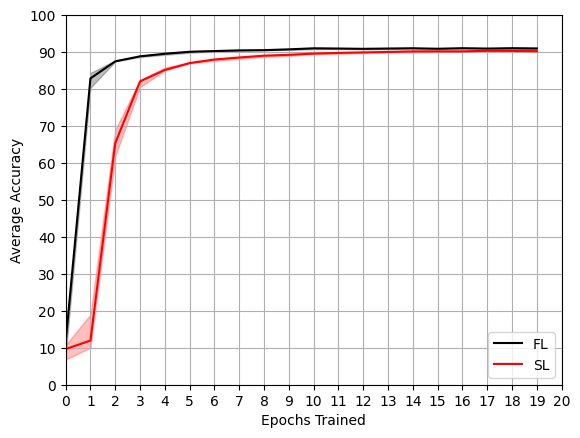

In [41]:
# aeg1
average_plot(find_data(db, condition=lambda ex: ex["exmajor"] == 0), label="FL", color=(0,0,0))
average_plot(find_data(db, condition=lambda ex: ex["exmajor"] == 3), label="SL", color=(1,0,0))
setup_accuracy_graph("Accuracy by Training Step for 6000 Samples")
plt.show()

\center{\textbf{Accuracy by Training Step for 1000 Samples}} \\


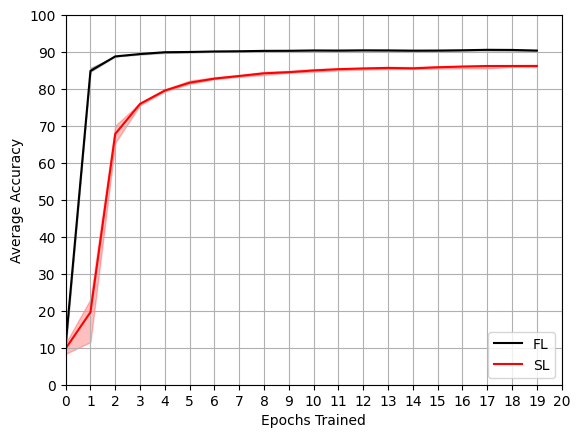

In [43]:
# aeg2
average_plot(find_data(db, condition=lambda ex: ex["exmajor"] == 1), label="FL", color=(0,0,0))
average_plot(find_data(db, condition=lambda ex: ex["exmajor"] == 4), label="SL", color=(1,0,0))
setup_accuracy_graph("Accuracy by Training Step for 1000 Samples")
plt.show()

\center{\textbf{Accuracy by Training Step for 100 Samples}} \\


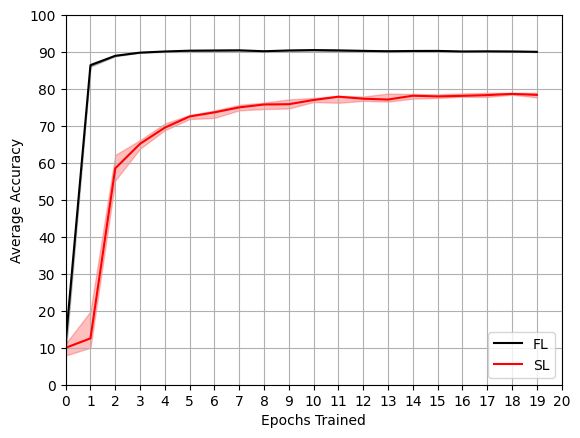

In [44]:
# aeg3
average_plot(find_data(db, condition=lambda ex: ex["exmajor"] == 2), label="FL", color=(0,0,0))
average_plot(find_data(db, condition=lambda ex: ex["exmajor"] == 5), label="SL", color=(1,0,0))
setup_accuracy_graph("Accuracy by Training Step for 100 Samples")
plt.show()

# IGNORE EVERYTHING BELOW HERE

In [44]:
def get_alternate_stats(data):
    xs, ys_avg, ys_q75, ys_q25 = get_average_plot(data)
    ys_std = ys_q75-ys_q25
    
    # Higher is better (0 (max accuracy 0 percent - 1 (max accuracy 100 percent))). The fraction of maxiumum possible value that was achived
    max_value = np.max(ys_avg) / 100
    # Higher is better (0 - 1). The fraction of possible area that the accuracy graph fills
    integral_fraction = np.sum(ys_avg) / (100*len(ys_avg))
    # Higher is better (0 (graph is reducing by infinity every timestep) - 1 (graph never goes down))
    stability = 0
    for i in range(1, len(ys_avg)):
        stability += min(0, ys_avg[i]-ys_avg[i-1])
    stability =  np.exp(stability)
    # Higher is better (0 (std is infinity every timestep) - 1 (std is 0 every timestep))
    consistency = np.exp(-np.sum(ys_std))
    return max_value, integral_fraction, stability, consistency

In [21]:
alphas = [0, 1, 0.9, 0.7, 0.5]
betas = [0, 0.5, 1.0, 2.0]
gammas = [0, 1, 3, 5]
data_stats = []
for a in alphas:
    for b in betas:
        for g in gammas:
            data_accuracy, data_msd = find_data(db, condition=lambda ex: (ex["density"], ex["alpha"], ex["beta"], ex["gamma"]) == (1,a,b,g))
            print(len(data_accuracy))
            max_val, integral, stability, consistency = get_alternate_stats(data_accuracy)
            data_stats.append([a, b, g, max_val, integral, stability, consistency])

df = pd.DataFrame(data_stats, columns=["alpha", "beta", "gamma", "peak", "fill", "stability", "consistency"])
df

8
8
8
8
8
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
8
8
8
8
8
8
8
8
8
8
6
6
6
6
6
6
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
10
10
10
10
10
10
10
10
10
10
8
8
8
8
8
8


,alpha,beta,gamma,peak,fill,stability,consistency
0,0.0,0.0,0,0.85980,0.779080,0.357007,1.691411e-36
1,0.0,0.0,1,0.87125,0.774792,0.358796,2.311763e-06
2,0.0,0.0,3,0.87255,0.778528,0.941765,6.272602e-14
3,0.0,0.0,5,0.87100,0.774218,0.826959,9.280593e-05
4,0.0,0.5,0,0.85555,0.771840,0.121238,3.543883e-32
...,...,...,...,...,...,...,...
75,0.5,1.0,5,0.86325,0.772467,0.055299,1.115008e-16
76,0.5,2.0,0,0.86265,0.780205,0.144424,9.821189e-24
77,0.5,2.0,1,0.86265,0.782570,0.878095,7.839710e-20
78,0.5,2.0,3,0.86375,0.773050,1.000000,1.407460e-21


## Top 5 Plots

In [9]:
def top_plot(n, by, title, plot_std=False, show_fl=False, zoom=False):
    df_fill = df.sort_values(by=by.split("|"), ascending=False).reset_index(drop=True).head(n)
    cols = colors((1,0,0), (0,0,1), n)
    df_fill=df_fill.iloc[::-1]
    for i, row in df_fill.iterrows():
        label = "%s: α=%.1f  β=%.1f  γ=%.1f"%(i+1, float(row['alpha']),float(row['beta']),float(row['gamma']))
        label = label.replace("α=0.0", "α=AVG").replace("β=9999.0", "β=-∞ ")
        average_plot(find_data(db, f"ex4B_({row['alpha']})_({row['beta']})_({row['gamma']})"), label=label, color=cols[i], plot_std=plot_std)
    if show_fl:
        average_plot(find_data(db, "fed"), label="Federated", color=(0,0,0), plot_std=False)
    setup_accuracy_graph(title, zoom=zoom)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(reversed(handles), reversed(labels))
    plt.show()

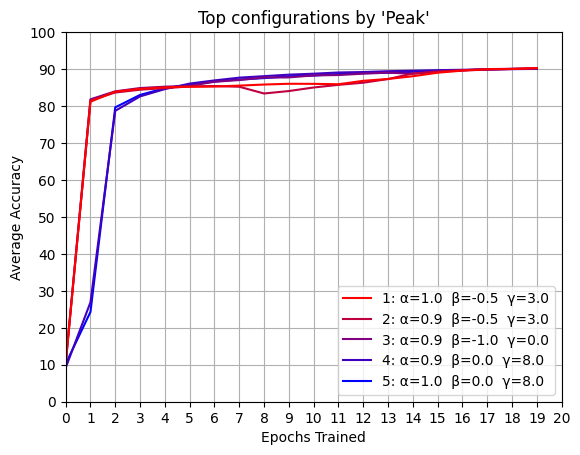

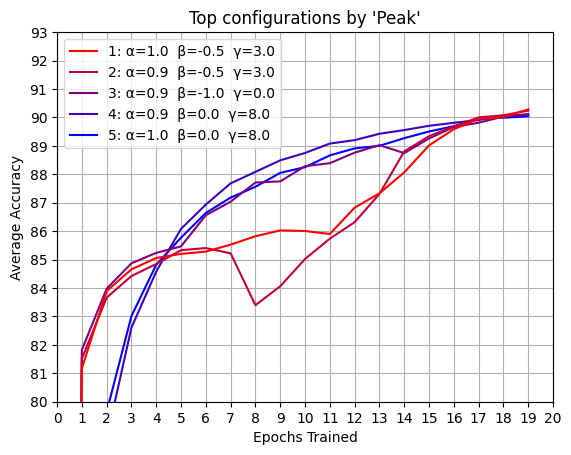

In [16]:
top_plot(5, "peak", "Top configurations by 'Peak'", show_fl=False)
top_plot(5, "peak", "Top configurations by 'Peak'", show_fl=False, zoom=True)

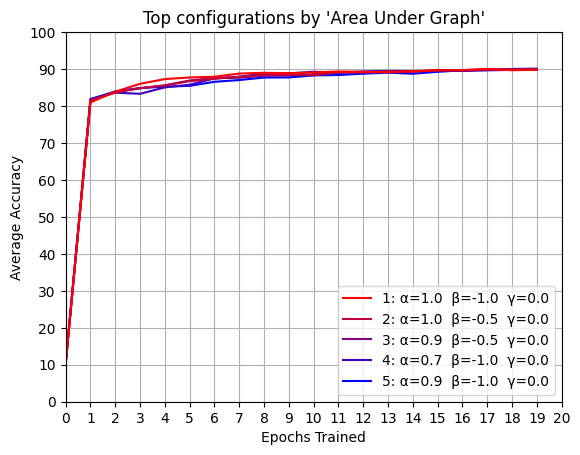

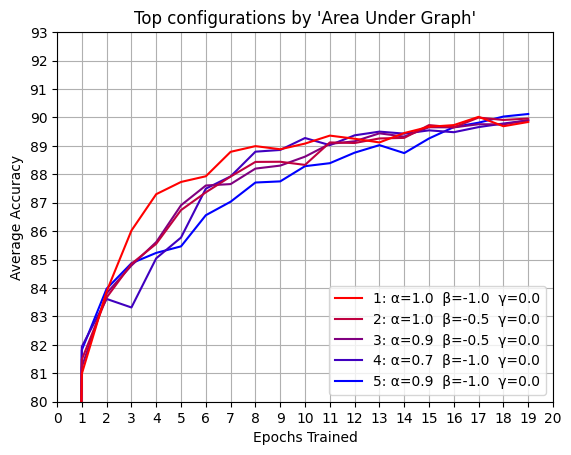

In [15]:
top_plot(5, "fill", "Top configurations by 'Area Under Graph'", show_fl=False)
top_plot(5, "fill", "Top configurations by 'Area Under Graph'", show_fl=False, zoom=True)

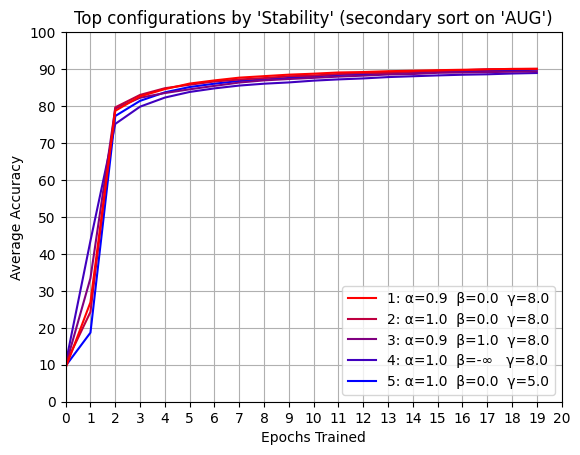

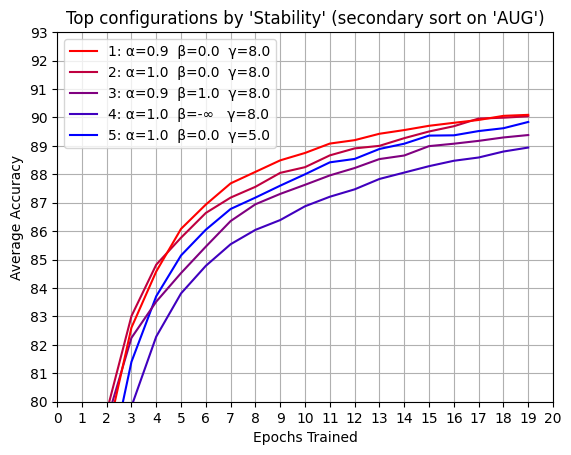

In [19]:
top_plot(5, "stability|fill", "Top configurations by 'Stability' (secondary sort on 'AUG')", show_fl=False)
top_plot(5, "stability|fill", "Top configurations by 'Stability' (secondary sort on 'AUG')", show_fl=False, zoom=True)

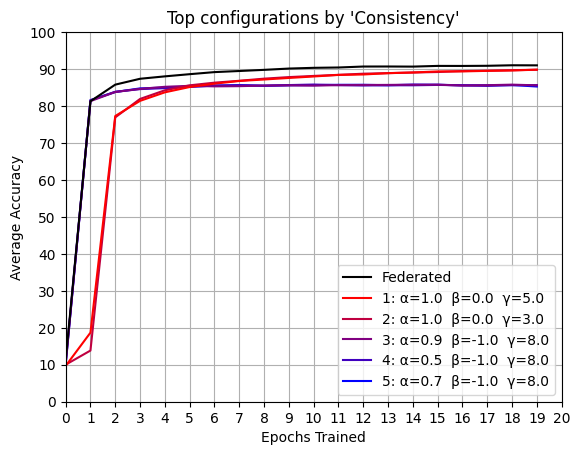

In [13]:
top_plot(5, "consistency", "Top configurations by 'Consistency'", show_fl=True)

## Comparison Of Top